In [1]:
!pip install laspy
!pip install laspy[lazrs]
!pip install laszip
!pip install open3d

In [18]:
import laspy
import numpy as np

# Load .las file
las = laspy.read("C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 las/Site1_1.las")

# Extract coordinates
points = np.vstack((las.x, las.y, las.z)).T
print(points.shape)  # (N, 3)


(306546, 3)


In [ ]:
import open3d as o3d

# Create an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

In [13]:
import pandas as pd

regions = pd.read_csv("C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 csv/Site1_1.csv")
print(regions.head())

           Name           X            Y       Z
0  Site1_1_P1_S  452625.500  7183542.099  145.54
1  Site1_1_P1_F  452625.658  7183541.602  145.53
2  Site1_1_P2_S  452626.749  7183538.561  145.52
3  Site1_1_P2_F  452627.003  7183538.362  145.57
4  Site1_1_P3_S  452642.015  7183501.636  145.79


In [14]:
# Group start and end points
regions['Group'] = regions['Name'].str.extract(r'(Site\d+_\d+_P\d+)')

# Pivot start and end
damage_regions = regions.pivot(index='Group', columns='Name', values=['X', 'Y', 'Z'])

In [20]:
import laspy
import numpy as np
import pandas as pd
import h5py
import os

# ==== INPUT FILES ====
las_file = "C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 las/Site1_1.las"
txt_file = "C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/site1 csv/Site1_1.csv"   # your .txt file with S/F lines
# Extract coordinates
points = np.vstack((las.x, las.y, las.z)).T
print(points.shape)  # (N, 3)

# ==== LOAD POINT CLOUD ====
las = laspy.read(las_file)
points = np.vstack((las.x, las.y, las.z)).T

# ==== LOAD DAMAGE COORDINATES ====
# Skip first 'Cartesian' line if it exists
with open(txt_file, 'r', encoding='utf-8', errors='ignore') as f:
    lines = [l for l in f.readlines() if not l.strip().startswith("Cartesian")]
from io import StringIO
df = pd.read_csv(StringIO("".join(lines)))

# Keep needed columns
df = df[["Name", "X", "Y", "Z"]]

# ==== BUILD DAMAGE BOXES ====
damage_boxes = []
for i in range(0, len(df), 2):  # assumes each S/F pair are consecutive
    name_start = df.iloc[i]["Name"]
    name_end   = df.iloc[i+1]["Name"]
    x1, y1, z1 = df.iloc[i][["X", "Y", "Z"]]
    x2, y2, z2 = df.iloc[i+1][["X", "Y", "Z"]]
    
    box = {
        'xmin': min(x1, x2),
        'xmax': max(x1, x2),
        'ymin': min(y1, y2),
        'ymax': max(y1, y2),
        'zmin': min(z1, z2),
        'zmax': max(z1, z2)
    }
    damage_boxes.append(box)

print(f"✅ Loaded {len(damage_boxes)} damage boxes")

# ==== LABEL POINTS ====
labels = np.zeros(len(points), dtype=int)

for box in damage_boxes:
    in_box = (
        (points[:,0] >= box['xmin']) & (points[:,0] <= box['xmax']) &
        (points[:,1] >= box['ymin']) & (points[:,1] <= box['ymax']) &
        (points[:,2] >= box['zmin']) & (points[:,2] <= box['zmax'])
    )
    labels[in_box] = 1  # mark as damaged

print(f"✅ Assigned {np.sum(labels)} damaged points out of {len(points)} total")

# ==== SAVE TO H5 ====
out_h5 = "C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/road_damage_points.h5"
with h5py.File(out_h5, "w") as f:
    f.create_dataset("data", data=points)
    f.create_dataset("label", data=labels)

print(f"🎉 Saved labeled data to {out_h5}")


(306546, 3)
✅ Loaded 20 damage boxes
✅ Assigned 497 damaged points out of 306546 total
🎉 Saved labeled data to C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/road_damage_points.h5


In [21]:
!pip install h5py

Points shape: (306546, 3)
Labels shape: (306546,)
Unique labels: [0 1]


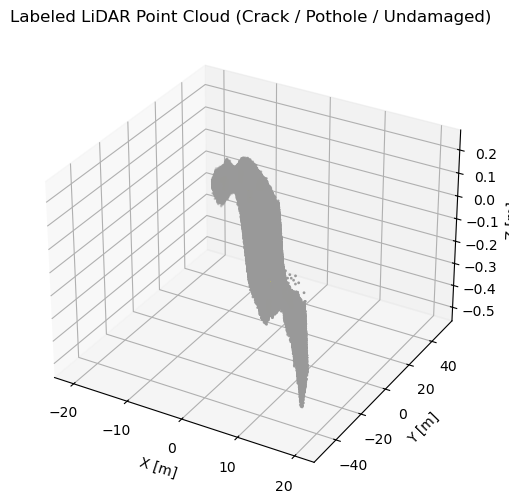

In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Load data ---
with h5py.File("C:/Users/umair.muhammad/Documents/PhD/Research Work/FedLearn/training/site1/road_damage_points.h5", "r") as f:
    points = np.array(f["data"])
    labels = np.array(f["label"])

print("Points shape:", points.shape)
print("Labels shape:", labels.shape)
print("Unique labels:", np.unique(labels))

# --- Assign colors ---
# Adjust color mapping based on your label scheme:
# 0 = undamaged (gray), 1 = crack (yellow), 2 = pothole (red)
colors = np.array([[0.6, 0.6, 0.6], [1, 1, 0], [1, 0, 0]])
c = np.array([colors[int(l)] for l in labels])

# --- Normalize for display ---
points -= np.mean(points, axis=0)

# --- 3D Scatter Visualization ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:,0], points[:,1], points[:,2], c=c, s=1)
ax.set_title("Labeled LiDAR Point Cloud (Crack / Pothole / Undamaged)")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
plt.show()